In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
path = "./Housing.csv"
housing = pd.read_csv(path)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [4]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [5]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [6]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


#### Splitting into train and test

In [7]:
df_train, df_test = train_test_split(housing, train_size=0.7, test_size=0.3, random_state=100)

# Rescale features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [8]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


In [9]:
# divide into x_train, y_train, x_test, y_test
y_train = df_train.pop('price')
x_train = df_train

y_test = df_test.pop('price')
x_test = df_test

In [10]:
# num of max features
len(x_train.columns)

13

 ## Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

<img src="./cv.png" title="K-Fold Cross Validation" />

#### K-fold CV

In [11]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [12]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=folds)
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [13]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

#### Hyperparameter tuning using Grid Search Cross-Validation

In [14]:
# number of features in X_train
len(x_train.columns)

13

In [15]:
# step-1: Create cross validation scheme
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]

# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(x_train, y_train)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator=rfe,
                       param_grid=hyper_params,
                       scoring='r2',
                       cv=folds,
                       verbose=1,
                       return_train_score=True)

# fit the model
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise-deprecating',
       estimator=RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=None, step=1, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [16]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017192,0.002929,0.001421,0.000112,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243471,0.077611,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.013470,0.000253,0.001454,0.000103,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438090,0.058533,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.015376,0.003329,0.001495,0.000391,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516555,0.060021,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.012182,0.001570,0.001266,0.000034,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526070,0.053150,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.010507,0.000061,0.001249,0.000011,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541765,0.049251,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.009588,0.000040,0.001249,0.000011,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.540988,0.047988,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.009559,0.001632,0.001263,0.000039,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577613,0.044949,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.008267,0.000746,0.001498,0.000347,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591740,0.039391,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.007064,0.000144,0.001368,0.000183,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615256,0.040756,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.006014,0.000075,0.001240,0.000016,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608457,0.043476,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


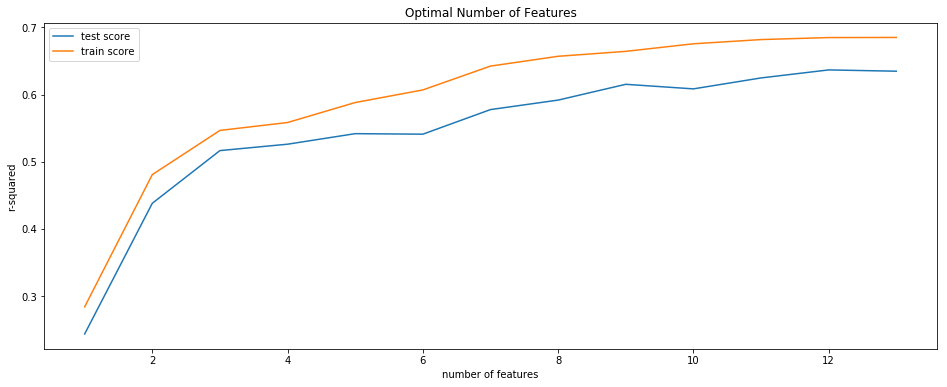

In [17]:
# plotting cv results
plt.figure(figsize=(16, 6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("r-squared")
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Now we can choose the optimal value of number of features and build a final model.

In [18]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(lm, n_features_to_select = n_features_optimal)
rfe = rfe.fit(x_train, y_train)

# predict prices of x_test
y_pred = lm.predict(x_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5995575338728532
